In [ ]:
import math
import matplotlib as plt
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from pathlib import Path
import sys

BASE_PATH = Path.cwd().parent
sys.path.append(str(BASE_PATH))

from model.sample_ballots import get_data, get_positions, fit_gmm, get_samples, N_VOTERS, PARTIES, EMISSION_DIST, PARTY_IDS, ELECTION_YEAR, ATTRIBUTES
from model.social_choice_functions import getPairMajMat

In [2]:
# Get Pairwise Majority Matrix - imported from model\social_choice_functions.py

In [3]:
def getTournAdjList(maj_mat: list[list[int]], n_alts: int):
    """
    Input: n*n Pairwise Majority matrix, where entry i,j represents the number of voters who prefer alternative i over j,
        number of alternatives
    Output: Adjacency list for the tournament
    """
    adj_mat = []
    for i in range(n_alts):
        connections = []
        for j in range(n_alts):
            if maj_mat[i][j] > maj_mat[j][i]: # connection only if strictly more voters prefer i over j
                connections.append(j)
        adj_mat.append(connections)  
    return adj_mat


In [4]:
def hasCycle(adj_list: list[list[int]], n_alts: int):
    """
    Input: n*n adjacency matrix for tournament,
        number of alternatives
    Output: Boolean, true is tournament has a cycle
    Idea: Carry out depth-first search (DFS) for each node in graph, if encounter same node twice in any search a cycle has been found
    """
    def DFSBreakOnCycle(adj_list: list[list[int]], visited: list[bool], in_stack: list[bool], start_node: int):
        visited[start_node] = True
        in_stack[start_node] = True # On path that is currently being explored

        for node in adj_list[start_node]:
            if not visited[node]:
                found_cycle = DFSBreakOnCycle(adj_list, visited, in_stack, node)
                if found_cycle:
                    return True
            elif in_stack[node]:
                return True # found cycle (node already visited and on current path)
        in_stack[start_node] = False # finished exploring start_node's paths
        return False


    for i in range(n_alts):
        found_cycle = DFSBreakOnCycle(adj_list, [False for j in range(n_alts)], [False for j in range(n_alts)], i)
        if found_cycle == True:
            return True # found cycle
    return False # not found cycle



**Run Analysis with 2 dimensions**

In [5]:

N_VOTERS = 100
N_SIMS = 10000 # Number of voting simulations

df = get_data(BASE_PATH, PARTY_IDS)
party_positions = get_positions(df, ATTRIBUTES)
gmm = fit_gmm(party_positions, PARTIES, EMISSION_DIST)

n_cycles = 0
for i in range(N_SIMS):
    voter_positions, _, sample_ballots = get_samples(gmm, party_positions, N_VOTERS)
    maj_mat = getPairMajMat(sample_ballots, len(PARTIES))
    adj_list = getTournAdjList(maj_mat, len(PARTIES))
    if hasCycle(adj_list, len(adj_list)):
        n_cycles += 1
        print("Cycle found")
print("Number of cycles =", n_cycles)
print("Probalility of a Condorcet Cycle ≈", n_cycles/N_SIMS)

    



Number of cycles = 0
Probalility of a Condorcet Cycle ≈ 0.0


**Check for single-peakedness**

In [6]:
# Define linear ordering, order alternitives by distance from origin.

linear_ordering = sorted(list(range(len(PARTIES))), key=lambda x: math.sqrt((party_positions[x][0]**2) + (party_positions[x][1]**2)))
for i in linear_ordering:
    print(i, PARTIES[i])

import itertools

def isBallotSinglePeaked(ballot, linear_ordering):
    top_ranked = ballot[0]
    for i in range(len(PARTIES)):
        for j in range(len(PARTIES)):
            if i == j or top_ranked == i or top_ranked == j:
                continue
            increasing_codition = (linear_ordering.index(top_ranked) < linear_ordering.index(i) < linear_ordering.index(j)) == (ballot.index(i) < ballot.index(j))
            decreasing_codition = (linear_ordering.index(top_ranked) > linear_ordering.index(i) > linear_ordering.index(j)) == (ballot.index(i) < ballot.index(j))
            
            if not increasing_codition and not decreasing_codition:
                #print(ballot)
                #print(i,j)
                return False # falsified
    return True

def numBallotsSinglePeaked(profile, linear_ordering):
    n_single_peaked = 0
    for ballot in profile:
        if isBallotSinglePeaked(ballot, linear_ordering):
            n_single_peaked += 1
    return n_single_peaked

#Find linear ordering which has highest proporton of single-peaked ballots
max_n_single_peaked = 0
for linear_ordering in itertools.permutations(list(range(len(PARTIES)))):
    n_single_peaked = numBallotsSinglePeaked(sample_ballots, linear_ordering)
    if n_single_peaked == len(sample_ballots):
        print("valid linear ordering:", linear_ordering)
    if n_single_peaked >= max_n_single_peaked:
        max_n_single_peaked = n_single_peaked

print("Proportion of ballots that are single-peaked under optimal linear ordering:", max_n_single_peaked/len(sample_ballots))

# PCA Analysis

from sklearn.decomposition import PCA
import numpy as np

X = np.array(voter_positions)

pca = PCA()
pca.fit(X)

print("Eigenvalues:", pca.explained_variance_)
print("Explained variance ratio:", pca.explained_variance_ratio_)

3 Green
2 LibDem
1 Lab
0 Cons
4 Reform
Proportion of ballots that are single-peaked under optimal linear ordering: 0.35
Eigenvalues: [15.0120675   1.31744484]
Explained variance ratio: [0.91932124 0.08067876]


**Sample with more Dimensions**

In [9]:
# Only update ATTRIBUTES
ATTRIBUTES = ["lrecon", "environment", "immigrate_policy"]

df = get_data(BASE_PATH, PARTY_IDS)
party_positions = get_positions(df, ATTRIBUTES)
gmm = fit_gmm(party_positions, PARTIES, EMISSION_DIST)

n_cycles = 0
for i in range(N_SIMS):
    _, _, sample_ballots = get_samples(gmm, party_positions, N_VOTERS)
    maj_mat = getPairMajMat(sample_ballots, len(PARTIES))
    adj_list = getTournAdjList(maj_mat, len(PARTIES))
    if hasCycle(adj_list, len(adj_list)):
        n_cycles += 1
        print("Cycle found")
print("Number of cycles =", n_cycles)
print("Probalility of a Condorcet Cycle ≈", n_cycles/N_SIMS)

Number of cycles = 0
Probalility of a Condorcet Cycle ≈ 0.0


**Sample voter weights for different attributes as well**

In [10]:
def sample_voter_weights(n_voters: int, n_dims: int, alpha: float):
    """
    Sample per-voter salience weights from a high-variance Dirichlet distribution.
    """
    return np.random.dirichlet([alpha] * n_dims, size=n_voters)

In [11]:
def compute_weighted_utilities(
    voter_positions: np.ndarray,    # shape: (N, d)
    party_positions: np.ndarray,    # shape: (M, d)
    voter_weights: np.ndarray       # shape: (N, d)
):
    """
    Returns utility matrix of shape (N, M)
    """
    N, d = voter_positions.shape
    M = party_positions.shape[0]

    utilities = np.zeros((N, M))

    for i in range(N):
        diff = party_positions - voter_positions[i]          # (M, d)
        utilities[i] = -np.sum(voter_weights[i] * diff**2, axis=1)
    return utilities


In [12]:
def utilities_to_ballots(utilities: np.ndarray):
    """
    Convert utilities to strict preference orderings.
    """
    ballots = []
    for i in range(utilities.shape[0]):
        ranking = np.argsort(-utilities[i])
        ballots.append(ranking.tolist())
    return ballots

In [13]:
ALPHA = 0.1 # Alpha of the Dirichlet ditribution to sample voter weights, variance scales roughly with 1/APLHA
n_dims = len(ATTRIBUTES)
df = get_data(BASE_PATH, PARTY_IDS)
party_positions = get_positions(df, ATTRIBUTES)
gmm = fit_gmm(party_positions, PARTIES, EMISSION_DIST)

n_cycles = 0

for sim in range(N_SIMS):

    # Sample voters (your existing code)
    voter_positions, _, _ = get_samples(gmm, party_positions, N_VOTERS)

    # Sample high-variance salience weights
    voter_weights = sample_voter_weights(
        n_voters=N_VOTERS,
        n_dims=n_dims,
        alpha=ALPHA
    )

    # Compute weighted utilities
    utilities = compute_weighted_utilities(
        voter_positions,
        party_positions,
        voter_weights
    )

    # Convert to ballots
    sample_ballots = utilities_to_ballots(utilities)

    # Check for cycles
    maj_mat = getPairMajMat(sample_ballots, len(PARTIES))
    adj_list = getTournAdjList(maj_mat, len(PARTIES))

    if hasCycle(adj_list, len(PARTIES)):
        n_cycles += 1
        print("Cycle found")

print("Number of cycles =", n_cycles)
print("Probability ≈", n_cycles / N_SIMS)


Cycle found
Cycle found
Cycle found
Cycle found
Cycle found
Cycle found
Cycle found
Cycle found
Cycle found
Cycle found
Cycle found
Cycle found
Cycle found
Cycle found
Cycle found
Cycle found
Cycle found
Cycle found
Number of cycles = 18
Probability ≈ 0.0018


**Test relationship between variance of Dirichlet dist and probability of cycle**

In [22]:
def test_alpha_vs_cycles(alpha_range: np.array, party_positions, n_dims: int, n_sims: int, n_voters: int, n_alts: int):
    
    alphas = []
    probabilities = []

    for alpha in alpha_range:
        n_cycles = 0

        for sim in range(n_sims):

            # Sample voters
            voter_positions, _, _ = get_samples(gmm, party_positions, n_voters)

            # Sample high-variance salience weights
            voter_weights = sample_voter_weights(
                n_voters=N_VOTERS,
                n_dims=n_dims,
                alpha=alpha
            )

            # Compute weighted utilities
            utilities = compute_weighted_utilities(
                voter_positions,
                party_positions,
                voter_weights
            )

            # Convert to ballots
            sample_ballots = utilities_to_ballots(utilities)

            # Check for cycles
            maj_mat = getPairMajMat(sample_ballots, n_alts)
            adj_list = getTournAdjList(maj_mat, n_alts)

            if hasCycle(adj_list, n_alts):
                n_cycles += 1

        alphas.append(alpha)
        probabilities.append(n_cycles/n_sims)
        print(alpha,":",n_cycles/n_sims)

    return pd.DataFrame({"Alpha": alphas, "Cycle Probability": probabilities}, columns = ["Alpha", "Cycle Probability"])

In [ ]:
alpha_range = np.arange(0.01, 0.401, 0.01)
alpha_vs_cycle_prob = test_alpha_vs_cycles(alpha_range, party_positions, len(ATTRIBUTES),  N_SIMS, N_VOTERS, len(PARTIES))

0.01 : 0.0063
0.02 : 0.0059
0.03 : 0.0044
0.04 : 0.0042
0.05 : 0.0039
0.060000000000000005 : 0.0036
0.06999999999999999 : 0.0021
0.08 : 0.0029
0.09 : 0.0013
0.09999999999999999 : 0.0018
0.11 : 0.0021
0.12 : 0.0011
0.13 : 0.0016
0.14 : 0.0014
0.15000000000000002 : 0.0009
0.16 : 0.0011
0.17 : 0.0007
0.18000000000000002 : 0.0008
0.19 : 0.0005
0.2 : 0.0008
0.21000000000000002 : 0.0003
0.22 : 0.0006
0.23 : 0.0001
0.24000000000000002 : 0.0005
0.25 : 0.0003
0.26 : 0.0002
0.27 : 0.0002
0.28 : 0.0003
0.29000000000000004 : 0.0001
0.3 : 0.0002
0.31 : 0.0
0.32 : 0.0
0.33 : 0.0004
0.34 : 0.0003
0.35000000000000003 : 0.0001
0.36000000000000004 : 0.0003
0.37 : 0.0
0.38 : 0.0
0.39 : 0.0


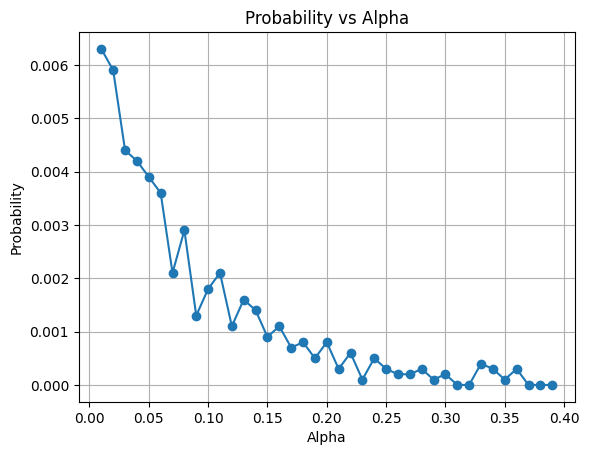

In [ ]:
plt.figure()

plt.plot(alpha_vs_cycle_prob["Alpha"], alpha_vs_cycle_prob["Cycle Probability"], marker="o")

plt.xlabel("Alpha")
plt.ylabel("Probability")
plt.title("Probability vs Alpha")

plt.grid(True)
plt.show()

**Same test with original 2 dimensions**

In [26]:
ATTRIBUTES = ["lrecon", "galtan"]
n_dims = len(ATTRIBUTES)
df = get_data(BASE_PATH, PARTY_IDS)
party_positions = get_positions(df, ATTRIBUTES)
gmm = fit_gmm(party_positions, PARTIES, EMISSION_DIST)

alpha_range = np.arange(0.1, 3, 0.1)
alpha_vs_cycle_prob = test_alpha_vs_cycles(alpha_range, party_positions, n_dims, N_SIMS, N_VOTERS, len(PARTIES))

0.1 : 0.0174
0.2 : 0.014
0.30000000000000004 : 0.0108
0.4 : 0.0099
0.5 : 0.0089
0.6 : 0.0081
0.7000000000000001 : 0.0075
0.8 : 0.007
0.9 : 0.0083
1.0 : 0.0077
1.1 : 0.0065
1.2000000000000002 : 0.0066
1.3000000000000003 : 0.0055
1.4000000000000001 : 0.0054
1.5000000000000002 : 0.0042
1.6 : 0.0054
1.7000000000000002 : 0.0055
1.8000000000000003 : 0.0048
1.9000000000000001 : 0.0033
2.0 : 0.0045
2.1 : 0.003
2.2 : 0.0024
2.3000000000000003 : 0.002
2.4000000000000004 : 0.0022
2.5000000000000004 : 0.0021
2.6 : 0.0022
2.7 : 0.0018
2.8000000000000003 : 0.0012
2.9000000000000004 : 0.0021


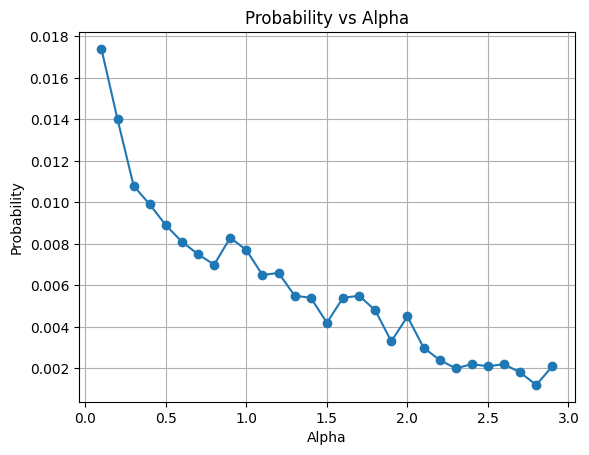

In [27]:
plt.figure()

plt.plot(alpha_vs_cycle_prob["Alpha"], alpha_vs_cycle_prob["Cycle Probability"], marker="o")

plt.xlabel("Alpha")
plt.ylabel("Probability")
plt.title("Probability vs Alpha")

plt.grid(True)
plt.show()

**Test smaller range (0.01-0.4)**

In [28]:
alpha_range = np.arange(0.01, 0.401, 0.01)
alpha_vs_cycle_prob = test_alpha_vs_cycles(alpha_range, party_positions, n_dims, N_SIMS, N_VOTERS, len(PARTIES))

0.01 : 0.0199
0.02 : 0.0185
0.03 : 0.0163
0.04 : 0.0199
0.05 : 0.0216
0.060000000000000005 : 0.0196
0.06999999999999999 : 0.0215
0.08 : 0.018
0.09 : 0.0179
0.09999999999999999 : 0.0181
0.11 : 0.0168
0.12 : 0.0143
0.13 : 0.0153
0.14 : 0.0143
0.15000000000000002 : 0.0171
0.16 : 0.0157
0.17 : 0.0161
0.18000000000000002 : 0.0144
0.19 : 0.0148
0.2 : 0.0148
0.21000000000000002 : 0.0162
0.22 : 0.011
0.23 : 0.0144
0.24000000000000002 : 0.0131
0.25 : 0.0135
0.26 : 0.0137
0.27 : 0.0139
0.28 : 0.0114
0.29000000000000004 : 0.0099
0.3 : 0.0113
0.31 : 0.0113
0.32 : 0.0116
0.33 : 0.0121
0.34 : 0.0106
0.35000000000000003 : 0.0105
0.36000000000000004 : 0.0111
0.37 : 0.0097
0.38 : 0.0088
0.39 : 0.0081
0.4 : 0.0083


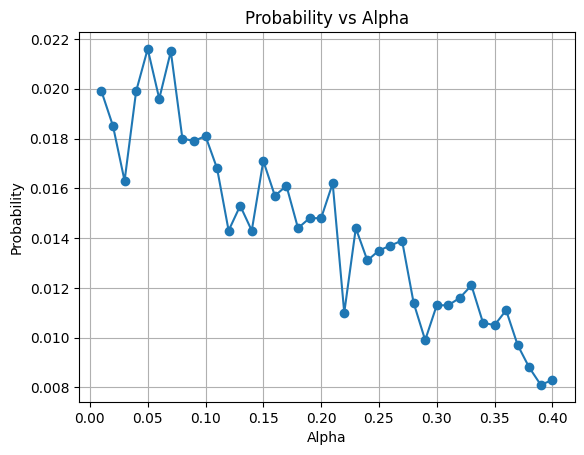

In [29]:
plt.figure()

plt.plot(alpha_vs_cycle_prob["Alpha"], alpha_vs_cycle_prob["Cycle Probability"], marker="o")

plt.xlabel("Alpha")
plt.ylabel("Probability")
plt.title("Probability vs Alpha")

plt.grid(True)
plt.show()

In [ ]:
"""Testing"""

profile = [
    [0,1,2],
    [1,2,0],
    [2,0,1]
]
maj_mat = getPairMajMat(profile,len(profile))
for row in maj_mat:
    print(row)
print("\n")
adj_list = getTournAdjList(maj_mat, len(maj_mat))
for row in adj_list:
    print(row)
    
print("\n")
print(hasCycle(adj_list, len(adj_list)))

[0, 2, 1]
[1, 0, 2]
[2, 1, 0]


[1]
[2]
[0]


True
